## Description of Notebook

The notebook is used to test ML approach on the VDF statistical momenta, anisotropies, and particle fraction numbers

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import seaborn as sns
import pandas as pd

In [2]:
def outputclass_analysis(test_labels, predicted_labels, output_score=''):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    print("------------ SUMMARY OF CLASSIFICATION RESULTS ----------------")
    print("TP = "+str(tp))
    print("TN = "+str(tn))
    print("FP = "+str(fp))
    print("FN = "+str(fn))
    precision = tp/(tp+fp) if ((tp+fp) != 0) else -999.9
    recall = tp/(tp+fn) if ((tp+fn) != 0) else -999.9
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn) if (((tp+fn) != 0) and ((fp+tn) != 0)) else -999.9
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))
    print("Accuracy = "+str(acc))
    print("TSS = "+str(tss))
    print("HSS = "+str(hss))
    if (output_score == 'TSS'): return tss
    if (output_score == 'HSS'): return hss
    if (output_score == 'precision'): return precision
    if (output_score == 'accuracy'): return acc
    return

def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    matrix_elements = confusion_matrix(test_labels, predicted_labels, labels=[0, 1]).ravel()
    tn, fp, fn, tp = matrix_elements
    precision = tp/(tp+fp) if ((tp+fp) != 0) else -999.9
    recall = tp/(tp+fn) if ((tp+fn) != 0) else -999.9
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn) if (((tp+fn) != 0) and ((fp+tn) != 0)) else -999.9
    return tp, tn, fp, fn, acc, tss

## Test 1. Preparation and testing of the data set (thres 0.001, unified labels, random split).

We have previously determined that the threshold of 0.001 provides the most reasonably-partitioned data set in case the labels for magnetic energy evolution and anisotropies are unified. The new elements here will be hyperparameter tuning for ML.

First, we load the data set, normalize it, and do some visualizations

In [3]:
freqs = np.load('./processing_results/fields.d10_E11Ap3.3Aa2.0Vd0.42.ps_freqs.npy')
print(freqs)

[-0.19047619 -0.17142857 -0.15238095 -0.13333333 -0.11428571 -0.0952381
 -0.07619048 -0.05714286 -0.03809524 -0.01904762  0.          0.01904762
  0.03809524  0.05714286  0.07619048  0.0952381   0.11428571  0.13333333
  0.15238095  0.17142857  0.19047619]


In [4]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_allps.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_allps.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_allps.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_allps.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 1596
Among them unstable (positive) samples: 418


In [5]:
featurevector_allmoments.shape

(1596, 30)

In [6]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments[:,:20])
featurevector_allmoments[:,:20] = scaler.transform(featurevector_allmoments[:,:20])

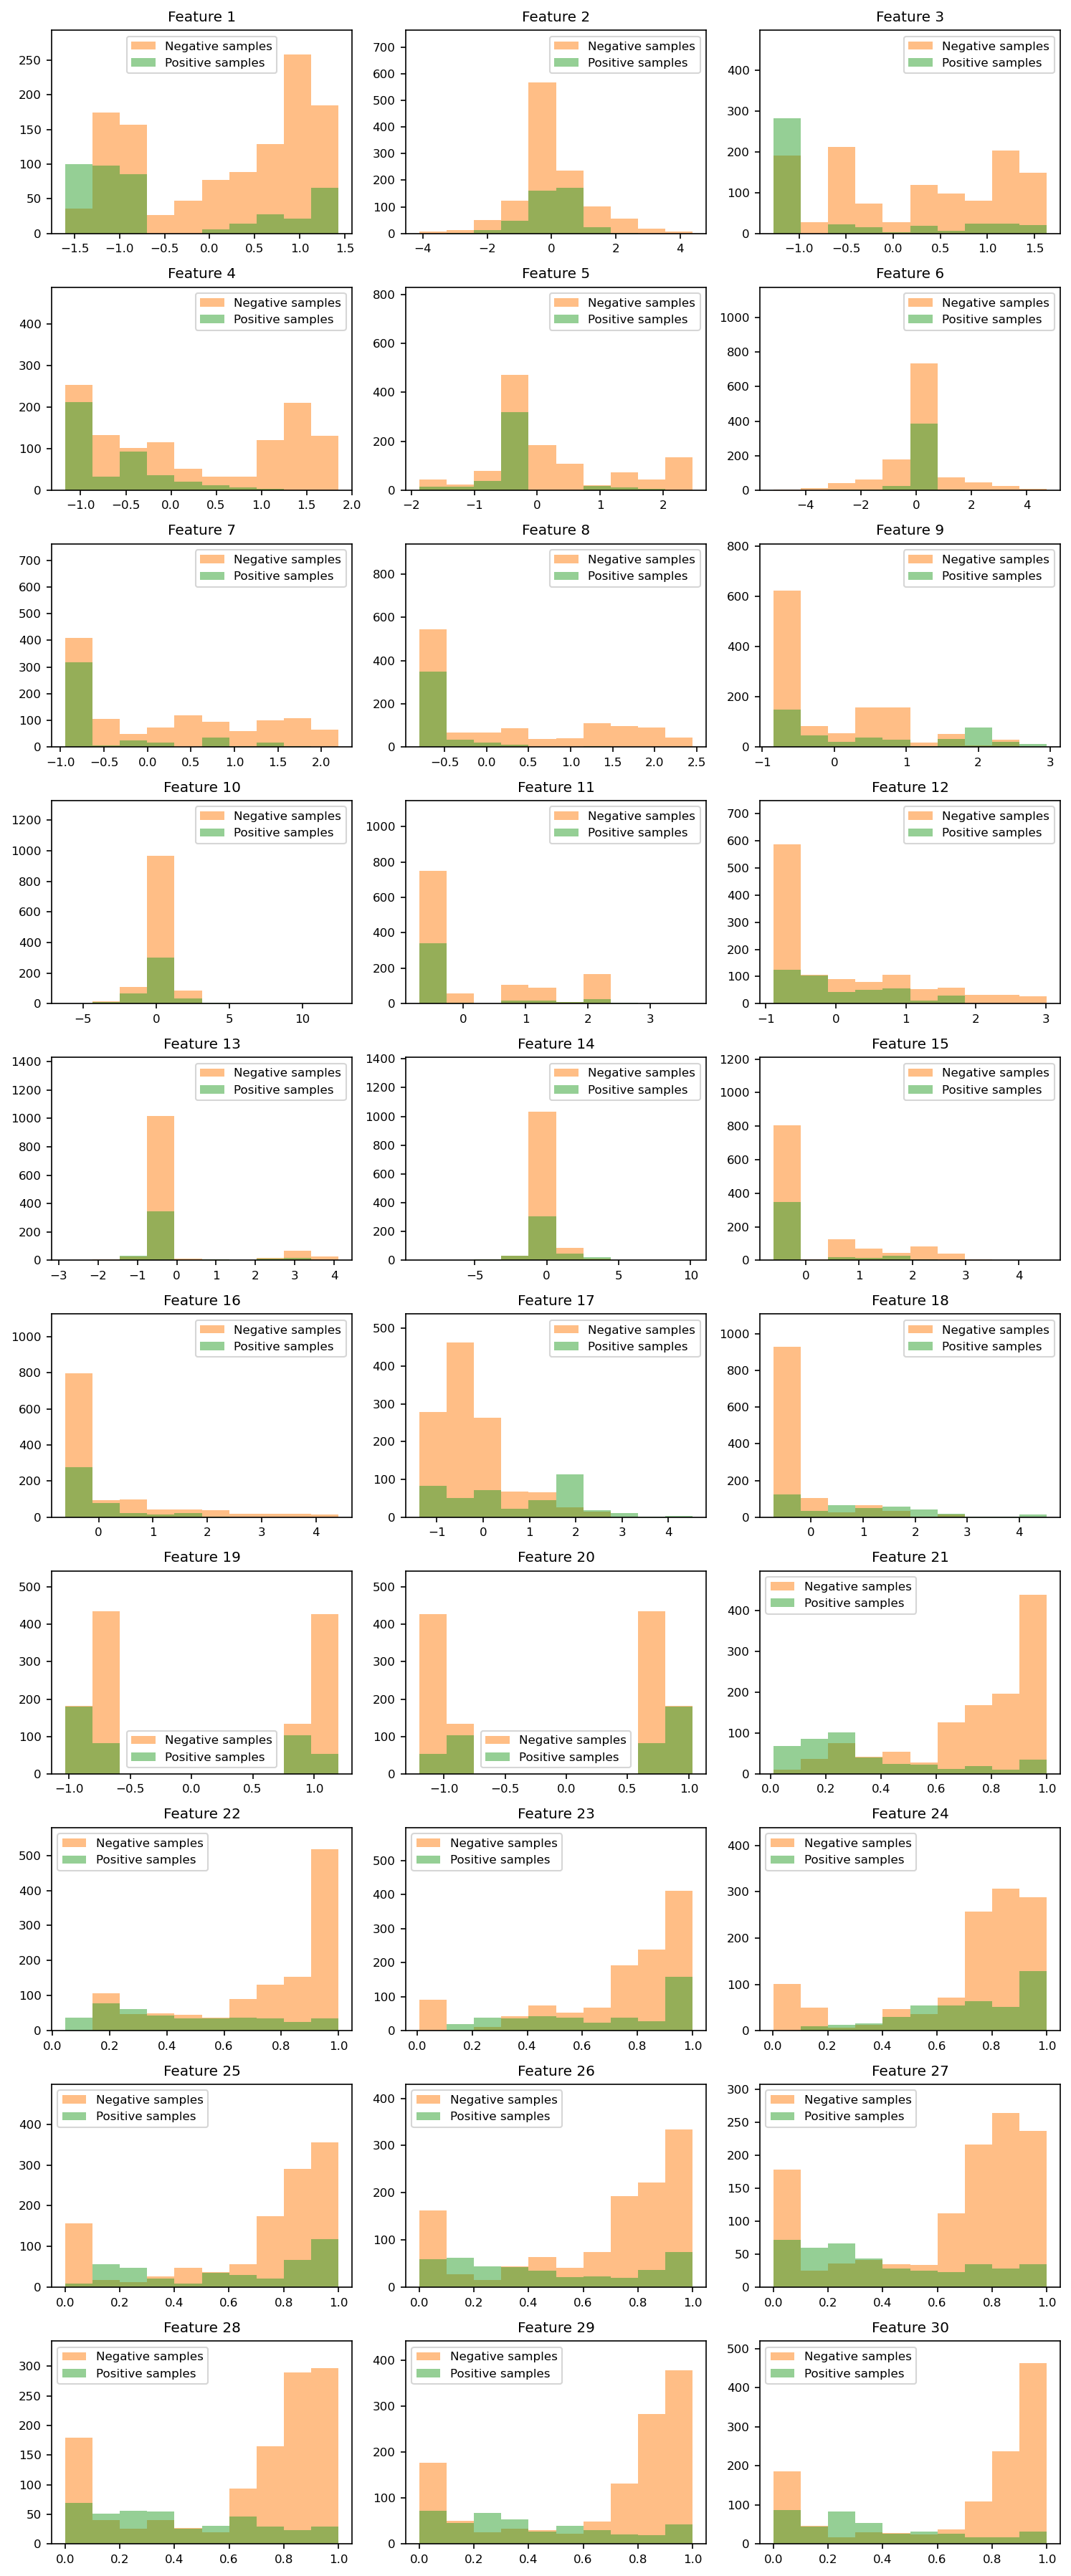

In [7]:
index_0 = np.where(labels_allmoments == 0)[0]
index_1 = np.where(labels_allmoments == 1)[0]

matplotlib.rcParams.update({'font.size':8})
im, ax = plt.subplots(10, 3, figsize = (10, 24), dpi=150)
for i in range (0, 10, 1):
    for j in range (0, 3, 1):
        hist, bins, patches = ax[i,j].hist(featurevector_allmoments[:,i*3+j], bins=10, alpha=0.00)
        ax[i,j].hist(featurevector_allmoments[index_0,i*3+j], bins=bins, label='Negative samples', alpha=0.50)
        ax[i,j].hist(featurevector_allmoments[index_1,i*3+j], bins=bins, label='Positive samples', alpha=0.50)
        ax[i,j].set(title='Feature '+str(i*3+j+1))
        ax[i,j].legend()

plt.tight_layout()
plt.show()

In [8]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)

In [9]:
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x0000018A660E66D0>

Next, we introduce the grid search procedure to determined the optimal parameters for the machine learning. The data set will be split according to the data_split function defined above. The parameters to test are different for different models, and therefore the dictionaries are defined differently.

### Case 1. kNN classifier.

In [11]:
# parameter grid
param_grid = {'n_neighbors': [2, 5, 10, 25], \
              'p': [1, 2]}

# classifier and gridsearch
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=1)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(labels_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameters found:  {'n_neighbors': 5, 'p': 1}
TP = 113.1+/-5.906775770248943
TN = 380.7+/-4.148493702538308
FP = 12.0+/-2.1447610589527217
FN = 21.2+/-3.4000000000000004
Acc = 0.9370018975332067+/-0.006395559600133874
TSS = 0.8113420455777515+/-0.025062557377563504


### Case 2. Support vector classifier with RBF kernel

In [12]:
# parameter grid
param_grid = {'kernel': ['rbf'], \
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], \
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 'scale'], \
              'class_weight': [None, 'balanced']}

# classifier and gridsearch
clf = SVC()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None,

[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s


[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END C=0.01, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] EN

[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0

[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weig

[CV] END ..C=10.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_we

[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_wei

[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total tim

[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   1.0s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   1.0s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   1.1s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=

[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.6s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.6s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.5s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.6s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.6s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.6s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.5s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.5s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.7s
[CV] END C=10000.0, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END C=10000.0, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END C=10000.0, class_weight=balanced, ga

### Case 3. Random Forest

In [13]:
# parameter grid
param_grid = {'n_estimators': [10,50,100,200], \
              'max_depth': [None, 2, 5, 10, 25], \
              'class_weight': [None, 'balanced']}

# classifier and gridsearch
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END .class_weight=None, max_depth=None, n

[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   1.1s
[CV] END ...class_weight=Non

[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=

[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   0.9s
[CV] END class_w

### Case 4. Neural Networks

In [14]:
# parameter grid
param_grid = {'hidden_layer_sizes': [(10,), (50,), (200,), (500,)], \
              'max_iter': [100, 250, 1000, 2500, 10000]}

# classifier and gridsearch
clf = MLPClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s
[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s
[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s
[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s
[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s
[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s
[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.8s
[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.4s
[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.6s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.6s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.6s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.6s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.6s
[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.7s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   1.8s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   1.9s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   1.6s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   1.5s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.1s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   1.8s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.5s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.3s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.1s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.0s
[CV] END ...........hidden_layer_sizes=(10,), max_iter=10000; total time=   1.7s
[CV] END ...........hidden_l

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.1s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.4s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.3s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.4s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.0s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.5s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.5s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.7s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.1s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.3s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   2.9s
[CV] END ............hidden_

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.6s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.2s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.4s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.7s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.7s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.4s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   3.9s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.9s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   3.4s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.6s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   2.9s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.5s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=2500; total time=   5.7s
[CV] END ...........hidden_l

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   4.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   4.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.4s
[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.5s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  10.5s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   6.8s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   9.4s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   6.4s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   7.8s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   9.4s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   7.1s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   8.7s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   7.6s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   8.2s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=2500; total time=   6.5s
[CV] END ...........hidden_l

### Visualizations for the best-fitted classifiers

In [15]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(labels_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(n_neighbors=5, p=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_knn = np.copy(tp)
tn_knn = np.copy(tn)
fp_knn = np.copy(fp)
fn_knn = np.copy(fn)
acc_knn = np.copy(acc)
tss_knn = np.copy(tss)

TP = 113.1+/-5.906775770248943
TN = 380.7+/-4.148493702538308
FP = 12.0+/-2.1447610589527217
FN = 21.2+/-3.4000000000000004
Acc = 0.9370018975332067+/-0.006395559600133874
TSS = 0.8113420455777515+/-0.025062557377563504


In [16]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(C=1000.0, class_weight=None, gamma=0.01, kernel='rbf')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_svm = np.copy(tp)
tn_svm = np.copy(tn)
fp_svm = np.copy(fp)
fn_svm = np.copy(fn)
acc_svm = np.copy(acc)
tss_svm = np.copy(tss)

TP = 117.9+/-5.974110812497539
TN = 378.6+/-4.586937976471886
FP = 14.1+/-3.5057096285916205
FN = 16.4+/-3.7735924528226414
Acc = 0.9421252371916509+/-0.00764920089971402
TSS = 0.8418369524050707+/-0.026426892457591354


In [17]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print ("Processing partition " + str(i))
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(class_weight = None, max_depth = None, n_estimators = 200, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_rf = np.copy(tp)
tn_rf = np.copy(tn)
fp_rf = np.copy(fp)
fn_rf = np.copy(fn)
acc_rf = np.copy(acc)
tss_rf = np.copy(tss)

Processing partition 0
Processing partition 1
Processing partition 2
Processing partition 3
Processing partition 4
Processing partition 5
Processing partition 6
Processing partition 7
Processing partition 8
Processing partition 9
TP = 121.0+/-5.513619500836088
TN = 385.3+/-5.404627646748664
FP = 7.4+/-3.2310988842807022
FN = 13.3+/-3.551056180912941
Acc = 0.960721062618596+/-0.00857256698146225
TSS = 0.8820726906134869+/-0.026486221419336292


In [18]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print ("Processing partition " + str(i))
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(hidden_layer_sizes = (200,), max_iter=10000, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_mlp = np.copy(tp)
tn_mlp = np.copy(tn)
fp_mlp = np.copy(fp)
fn_mlp = np.copy(fn)
acc_mlp = np.copy(acc)
tss_mlp = np.copy(tss)

Processing partition 0
Processing partition 1
Processing partition 2
Processing partition 3
Processing partition 4
Processing partition 5
Processing partition 6
Processing partition 7
Processing partition 8
Processing partition 9
TP = 115.3+/-5.967411499134277
TN = 376.4+/-5.023942674832188
FP = 16.3+/-2.5709920264364885
FN = 19.0+/-4.147288270665544
Acc = 0.9330170777988614+/-0.006409618881994129
TSS = 0.816894976260626+/-0.0275366915736019


In [19]:
# from the CNN notebook

acc_cnn15 = np.array([0.9468690702087287, 0.9297912713472486, 0.9165085388994307, 0.9165085388994307, 0.937381404174573, \
0.8975332068311196, 0.8823529411764706, 0.9411764705882353, 0.9184060721062619, 0.920303605313093], dtype=float)

tss_cnn15 = np.array([0.8143773138429831, 0.7616503186901263, 0.7203886375435733, 0.7221853082318199, 0.7783221298089704, \
0.6576800415337832, 0.6472389071885294, 0.8369984424831269, 0.682384792177944, 0.7122834645669291], dtype=float)

acc_cnn10 = np.array([0.9335863377609108, 0.9259962049335864, 0.9506641366223909, 0.9316888045540797, 0.937381404174573, \
0.9070208728652751, 0.9070208728652751, 0.9278937381404174, 0.8937381404174574, 0.9127134724857685], dtype=float)

tss_cnn10 = np.array([0.7617457348956147, 0.706766917293233, 0.8406511903878959, 0.7975636766334442, 0.7783221298089704, \
0.6613327894385522, 0.6748110831234256, 0.758937180152785, 0.5763702232090686, 0.6431692913385827], dtype=float)

#ARCH = VDFCNN_4040_CNN1_CONN2
#TP = 101.7+/-9.209234495874236
#TN = 383.5+/-7.116881339463234
#FP = 9.2+/-5.6000000000000005
#FN = 32.6+/-7.605261336732618
#Acc = 0.9206831119544592+/-0.01874240337740531
#TSS = 0.7333509356067786+/-0.06050354304379169

#ARCH = VDFCNN_6060_CNN1_CONN2
#TP = 98.7+/-13.505924625881784
#TN = 387.6+/-6.959885056522126
#FP = 5.1+/-3.645545226711637
#FN = 35.6+/-10.229369482035537
#Acc = 0.9227703984819735+/-0.01632430073169117
#TSS = 0.7199670216281573+/-0.07708733285096532

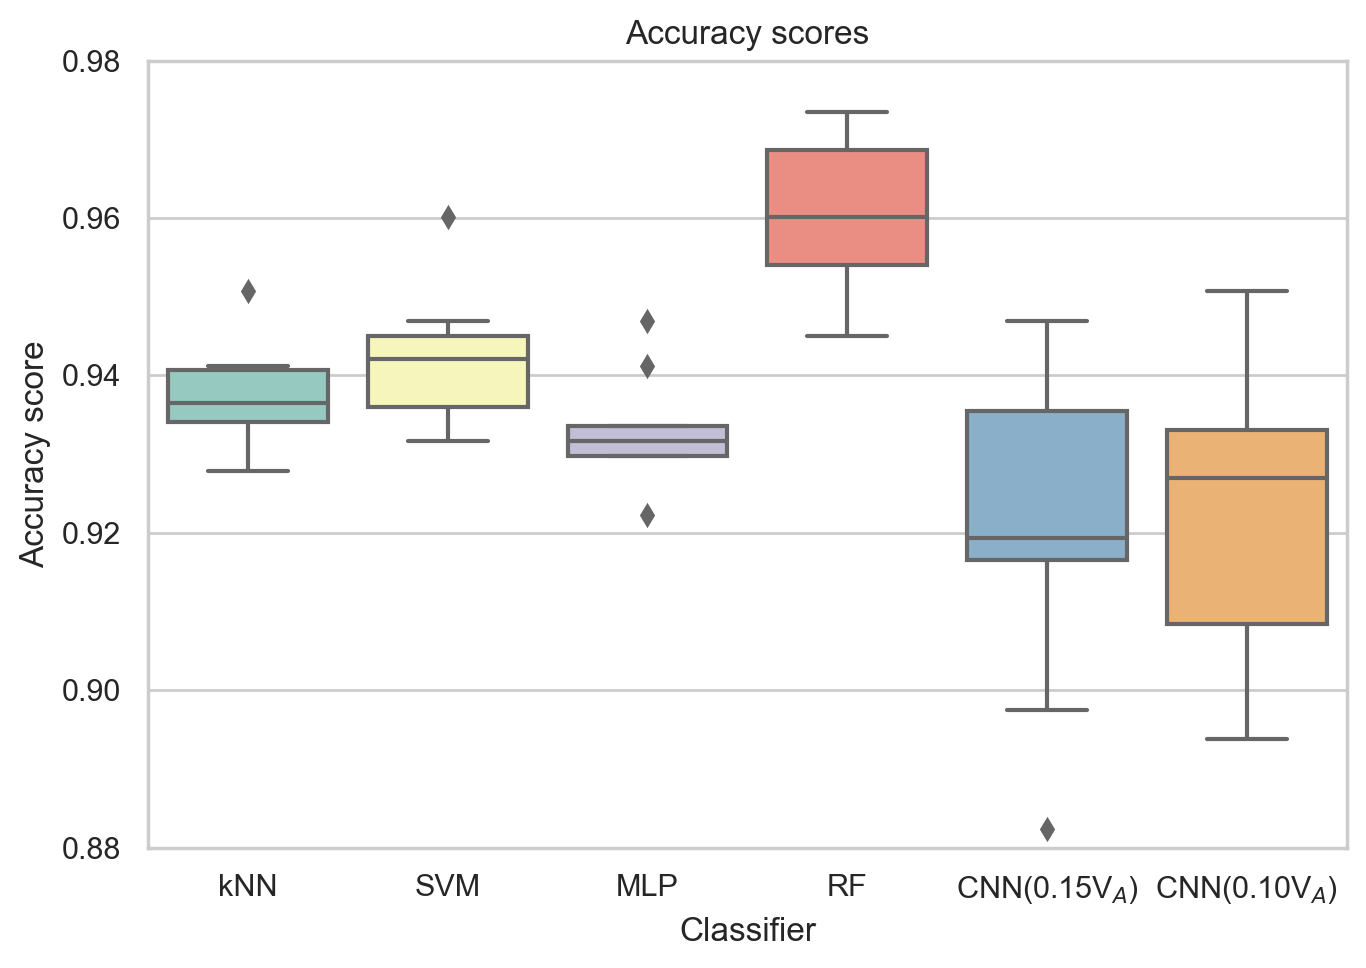

In [22]:
matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(7,5), dpi=200)
sns.set(style="whitegrid")

data = {
    'kNN': acc_knn,
    'SVM': acc_svm,
    'MLP': acc_mlp,
    'RF': acc_rf,
    r'CNN(0.15V$_{A}$)': acc_cnn15,
    r'CNN(0.10V$_{A}$)': acc_cnn10
} 

df = pd.DataFrame([(group, score) for group, scores in data.items() for score in scores], \
                  columns=['Classifier', 'Accuracy score'])

ax = sns.boxplot(x='Classifier', y='Accuracy score', data=df, palette="Set3")
ax.set(xlabel='Classifier', ylabel='Accuracy score', title='Accuracy scores')
ax.set(ylim=[0.88,0.98])

plt.tight_layout()
plt.savefig('./visualizations_paper/accuracy_boxplot_ps_norm.png')
plt.show()

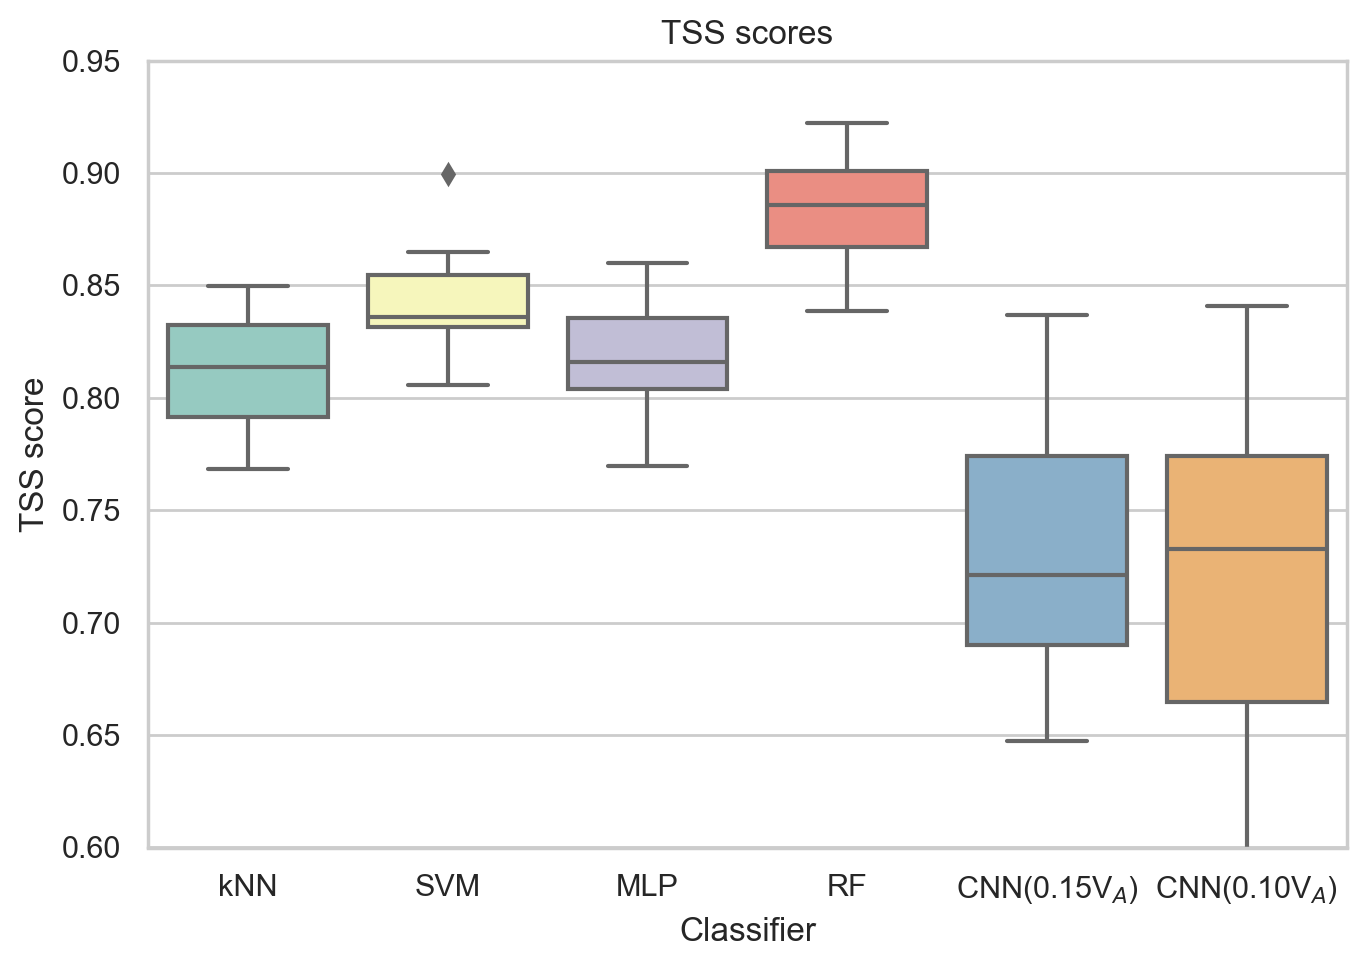

In [23]:
matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(7,5), dpi=200)
sns.set(style="whitegrid")

data = {
    'kNN': tss_knn,
    'SVM': tss_svm,
    'MLP': tss_mlp,
    'RF': tss_rf, 
    r'CNN(0.15V$_{A}$)': tss_cnn15,
    r'CNN(0.10V$_{A}$)': tss_cnn10
}

#, 
#    

df = pd.DataFrame([(group, score) for group, scores in data.items() for score in scores], \
                  columns=['Classifier', 'TSS score'])

ax = sns.boxplot(x='Classifier', y='TSS score', data=df, palette="Set3")
ax.set(xlabel='Classifier', ylabel='TSS score', title='TSS scores')
ax.set(ylim=[0.60,0.95])

plt.tight_layout()
plt.savefig('./visualizations_paper/tss_boxplot_ps_norm.png')
plt.show()

## Test 2. Testing performance for any 'unseen' run

In [24]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_allps.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_allps.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_allps.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_allps.npy')
simnames = np.load('./mldata_vdfmoments/allsimulations.simnames_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 1596
Among them unstable (positive) samples: 418


In [25]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments[:,:20])
featurevector_allmoments[:,:20] = scaler.transform(featurevector_allmoments[:,:20])

In [26]:
simfiles = [\
'particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
'particles.d11_A0.75Hepp_beta1_256',\
'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
'particles.d11_E11Ap4.3Aa1.6',\
'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
'particles.d11_He++A10_256_iden0eps0',\
'particles.d11_He++v2_256_iden0eps1e-4t600',\
'particles.d11_He++vd1.5_256_iden0eps1e-4',\
'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
'particles.d11_vap1.5Ap1.5Aa1rdna_0.007',\
'particles.d11_e260945ap1.30.5_1',\
'particles.d11_e260955ap2.20.4_2',\
'particles.d11_e261013ap1.50.6_3',\
'particles.d11_e261016ap1.70.6_4',\
'particles.d11_e261019ap1.50.4_5',\
'particles.d11_e261022ap1.40.4_6',\
'particles.d11_e261040ap1.40.4_7',\
'particles.d11_pv1.4av2Ap2Apb2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2Ap2Apb2beta_pb0.429_128_128x2_dx0.75',\
'particles.d11_pv2av1.4Ap1Aa1betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Aa2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Ab2beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap2Aa2beta0.429_128_128x4_dx0.75_t3000']

### Statistics for every run using Random Forest (best parameters)

In [27]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(class_weight = None, max_depth = None, n_estimators = 200, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_rf = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=23, tn=6, fp=0, fn=17 , accuracy=0.63
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=41, tn=0, fp=5, fn=0 , accuracy=0.89
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=43, fp=5, fn=0 , accuracy=0.89
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=45, tn=0, fp=1, fn=0 , accuracy=0.97
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=31, tn=6, fp=0, fn=53 , accuracy=0.41
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=50, tn=0, fp=28, fn=0 , accuracy=0.64
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=0

### Statistics for every run using kNN classifier (best parameters)

In [28]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(n_neighbors=5, p=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_knn = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=35, tn=0, fp=6, fn=5 , accuracy=0.76
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=36, tn=0, fp=5, fn=5 , accuracy=0.78
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=46, fp=2, fn=0 , accuracy=0.95
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=35, tn=0, fp=1, fn=10 , accuracy=0.76
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=10, tn=6, fp=0, fn=74 , accuracy=0.17
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=34, tn=1, fp=27, fn=16 , accuracy=0.44
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=

### Statistics for every run using SVM classifier (best parameters)

In [29]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(C=1000.0, class_weight=None, gamma=0.01, kernel='rbf')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_svm = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=40, tn=0, fp=6, fn=0 , accuracy=0.86
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=31, tn=2, fp=3, fn=10 , accuracy=0.71
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=48, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=20, tn=1, fp=0, fn=25 , accuracy=0.45
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=45, tn=6, fp=0, fn=39 , accuracy=0.56
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=25, tn=0, fp=28, fn=25 , accuracy=0.32
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=

### Statistics for every run using MLP classifier (best parameters)

In [30]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(hidden_layer_sizes = (200,), max_iter=10000, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_mlp = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=40, tn=0, fp=6, fn=0 , accuracy=0.86
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=33, tn=0, fp=5, fn=8 , accuracy=0.71
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=48, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=18, tn=1, fp=0, fn=27 , accuracy=0.41
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=32, tn=6, fp=0, fn=52 , accuracy=0.42
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=45, tn=0, fp=28, fn=5 , accuracy=0.57
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=0,

In [31]:
accuracies_cnn15 = np.array([1.,         1.,         0.56521739, 0.89130435, 0.93478261, 0.9375, \
 0.97826087, 0.3,        0.64102564, 0.52027027, 0.98275862, 0.8630137, \
 0.72413793, 0.98275862, 0.98275862, 0.55737705, 0.85714286, 1., \
 0.81818182, 1.,         1.,         1.,         1.,         1., \
 1.,         1.,         1.,         0.96551724, 0.5,        0.75862069, \
 0.98275862, 0.98275862, 0.65517241, 0.96551724], dtype=float)

accuracies_cnn10 = np.array([1.,         1.,         0.34782609, 0.91304348, 0.89130435, 0.91666667, \
 0.97826087, 0.26666667, 0.64102564, 0.48648649, 0.98275862, 0.8630137, \
 0.72413793, 0.96551724, 0.98275862, 0.55737705, 0.85714286, 1., \
 0.95454545, 1.,         1.,         1.,         1.,         1., \
 1.,         1.,         1.,         0.96551724, 1.,         0.56896552, \
 0.98275862, 0.98275862, 0.65517241, 0.98275862], dtype=float) 

In [32]:
print(np.mean(accuracies_cnn15), np.std(accuracies_cnn15))
print(np.mean(accuracies_cnn10), np.std(accuracies_cnn10))

0.863142210882353 0.18762798505931302
0.8666606694117647 0.20290373051250807


### Visualizing a bar chart for every model

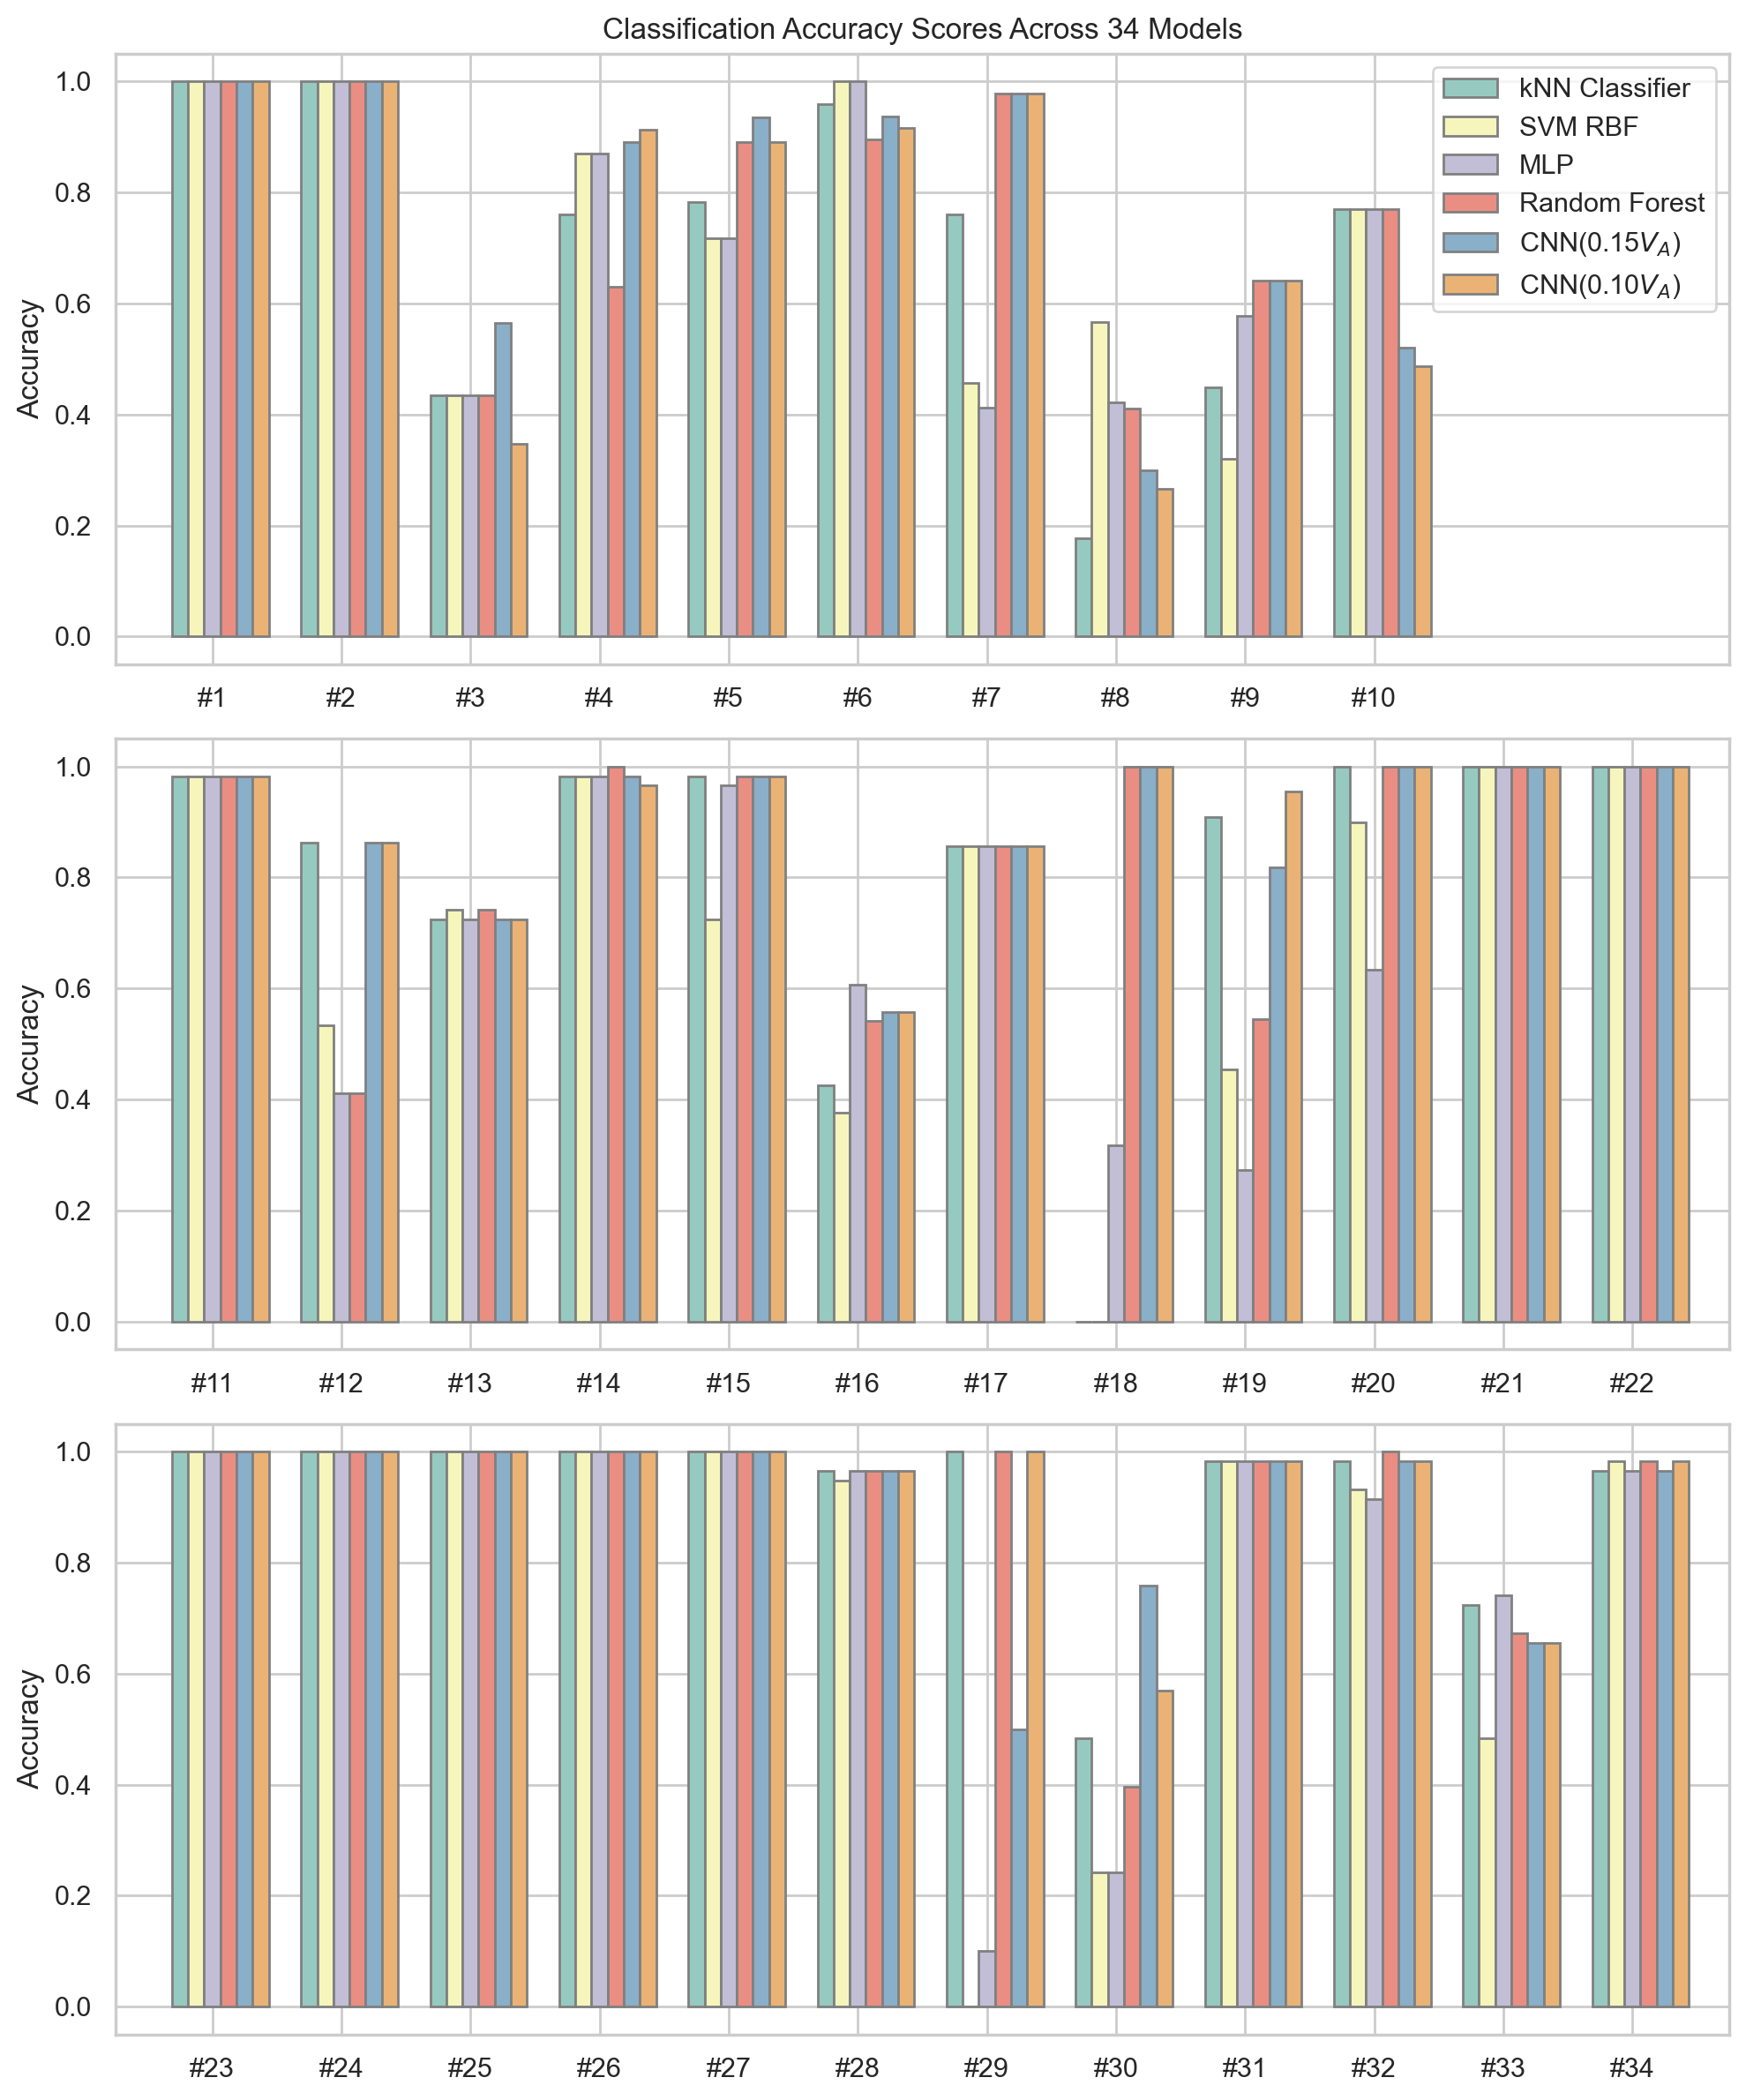

In [33]:
matplotlib.rcParams.update({'font.size':10})

modelnames = np.arange(1, 35)

# Set the bar width and positions
bar_width = 0.125
r1 = np.arange(len(modelnames))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

im, ax = plt.subplots(3, 1, figsize=(10, 12), dpi=200)



# Plotting the bar chart
ax[0].bar(r1[0:10], accuracies_knn[0:10], bar_width, color='#96cac1', edgecolor='grey', label='kNN Classifier')
ax[0].bar(r2[0:10], accuracies_svm[0:10], bar_width, color='#f6f6bc', edgecolor='grey', label='SVM RBF')
ax[0].bar(r3[0:10], accuracies_mlp[0:10], bar_width, color='#c1bed6', edgecolor='grey', label='MLP')
ax[0].bar(r4[0:10], accuracies_rf[0:10], bar_width, color='#ea8e83', edgecolor='grey', label='Random Forest')
ax[0].bar(r5[0:10], accuracies_cnn15[0:10], bar_width, color='#8aafc9', edgecolor='grey', label=r'CNN(0.15$V_{A}$)')
ax[0].bar(r6[0:10], accuracies_cnn10[0:10], bar_width, color='#eab375', edgecolor='grey', label=r'CNN(0.10$V_{A}$)')

simfilelabels_simp = ['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']

# Adding labels and title
ax[0].set(ylabel='Accuracy', title='Classification Accuracy Scores Across 34 Models', ylim=[-0.05,1.05], xlim=[-0.5,12])
ax[0].set_xticks([r + 2*bar_width for r in range(len(modelnames[:10]))])
ax[0].set_xticklabels(simfilelabels_simp)

# Adding legend
ax[0].legend()





ax[1].bar(r1[0:12], accuracies_knn[10:22], bar_width, color='#96cac1', edgecolor='grey', label='kNN Classifier')
ax[1].bar(r2[0:12], accuracies_svm[10:22], bar_width, color='#f6f6bc', edgecolor='grey', label='SVM RBF')
ax[1].bar(r3[0:12], accuracies_mlp[10:22], bar_width, color='#c1bed6', edgecolor='grey', label='MLP')
ax[1].bar(r4[0:12], accuracies_rf[10:22], bar_width, color='#ea8e83', edgecolor='grey', label='Random Forest')
ax[1].bar(r5[0:12], accuracies_cnn15[10:22], bar_width, color='#8aafc9', edgecolor='grey', label=r'CNN(0.15$V_{A}$)')
ax[1].bar(r6[0:12], accuracies_cnn10[10:22], bar_width, color='#eab375', edgecolor='grey', label=r'CNN(0.10$V_{A}$)')

simfilelabels_simp = ['#11', '#12', '#13', '#14', '#15', '#16', '#17', '#18', '#19', '#20', '#21', '#22']

# Adding labels and title
ax[1].set(ylabel='Accuracy', ylim=[-0.05,1.05], xlim=[-0.5,12])
ax[1].set_xticks([r + 2*bar_width for r in range(len(modelnames[:12]))])
ax[1].set_xticklabels(simfilelabels_simp)




ax[2].bar(r1[0:12], accuracies_knn[22:34], bar_width, color='#96cac1', edgecolor='grey', label='kNN Classifier')
ax[2].bar(r2[0:12], accuracies_svm[22:34], bar_width, color='#f6f6bc', edgecolor='grey', label='SVM RBF')
ax[2].bar(r3[0:12], accuracies_mlp[22:34], bar_width, color='#c1bed6', edgecolor='grey', label='MLP')
ax[2].bar(r4[0:12], accuracies_rf[22:34], bar_width, color='#ea8e83', edgecolor='grey', label='Random Forest')
ax[2].bar(r5[0:12], accuracies_cnn15[22:34], bar_width, color='#8aafc9', edgecolor='grey', label=r'CNN(0.15$V_{A}$)')
ax[2].bar(r6[0:12], accuracies_cnn10[22:34], bar_width, color='#eab375', edgecolor='grey', label=r'CNN(0.10$V_{A}$)')

simfilelabels_simp = ['#23', '#24', '#25', '#26', '#27', '#28', '#29', '#30', '#31', '#32', '#33', '#34']

# Adding labels and title
ax[2].set(ylabel='Accuracy', ylim=[-0.05,1.05], xlim=[-0.5,12])
ax[2].set_xticks([r + 2*bar_width for r in range(len(modelnames[:12]))])
ax[2].set_xticklabels(simfilelabels_simp)




plt.tight_layout()
plt.savefig('./visualizations_paper/accuracy_allmodels_ps_norm.png')
plt.show()

## Test 2. Understanding the parameter space

There are several actions that could be done here, including (1) understanding what simulation runs produce the largest number of incorrect predictions, and (2) figuring out where the incorrect predictions are on the 'Brazil' plot, for the beginnning, and (3) comparison of random forest with others.

In [13]:
def outputclass_indexes(test_labels, predicted_labels):
    indexes_tp = []
    indexes_tn = []
    indexes_fp = []
    indexes_fn = []
    for j in range (0, len(test_labels), 1):
        if ((test_labels[j] == 1) and (predicted_labels[j] == 1)): indexes_tp.append(j)
        if ((test_labels[j] == 0) and (predicted_labels[j] == 0)): indexes_tn.append(j)
        if ((test_labels[j] == 0) and (predicted_labels[j] == 1)): indexes_fp.append(j)
        if ((test_labels[j] == 1) and (predicted_labels[j] == 0)): indexes_fn.append(j)
    return indexes_tp, indexes_tn, indexes_fp, indexes_fn

In [14]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_allps.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_allps.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_allps.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_allps.npy')

# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

scaler = StandardScaler()
scaler.fit(featurevector_allmoments[:,:20])
featurevector_allmoments[:,:20] = scaler.transform(featurevector_allmoments[:,:20])

data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)

data_split.split(labels_allmoments)

indexes_tp_all = []
indexes_tn_all = []
indexes_fp_all = []
indexes_fn_all = []

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print("Processing:", i)
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(class_weight = None, max_depth = None, n_estimators = 200, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    indexes_tp, indexes_tn, indexes_fp, indexes_fn = outputclass_indexes(f_test, f_predicted)
    indexes_tp_all.append(test_index[indexes_tp])
    indexes_tn_all.append(test_index[indexes_tn])
    indexes_fp_all.append(test_index[indexes_fp])
    indexes_fn_all.append(test_index[indexes_fn])

Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9


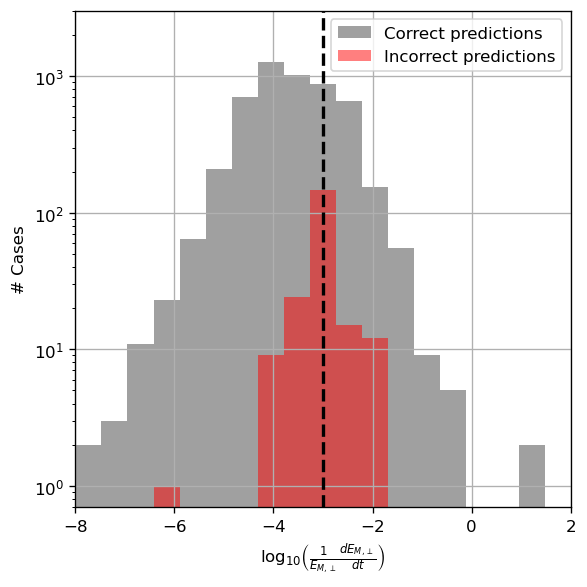

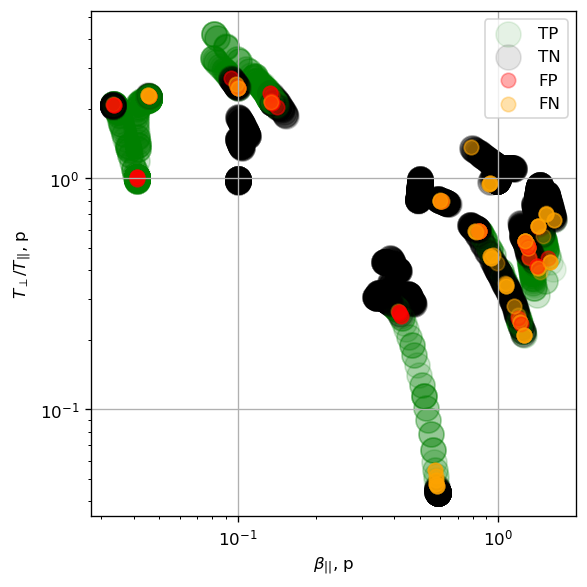

In [15]:
# Histogram for predicted rates
re_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_re_all.npy')
re_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_re_all.npy')

re_max = np.copy(np.abs(re_me))
    
cases_positive = []
cases_negative = []

for i in range (0, 10, 1):
    cases_positive.extend(re_max[indexes_tp_all[i]])
    cases_positive.extend(re_max[indexes_tn_all[i]])
    cases_negative.extend(re_max[indexes_fp_all[i]])
    cases_negative.extend(re_max[indexes_fn_all[i]])
    
cases_positive = np.array(cases_positive)
cases_negative = np.array(cases_negative)

matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(5,5), dpi=120)

plt.grid(True)

bins = np.linspace(-8, 2, 20)
ax.hist(np.log10(cases_positive), color='gray', alpha=0.75, bins=bins, label='Correct predictions')
ax.hist(np.log10(cases_negative), color='red', alpha=0.50, bins=bins, label='Incorrect predictions')
ax.plot([-3,-3], [0.7, 3000.0], color='black', linestyle='--', linewidth=2.0)

ax.set(yscale='log', xlabel=r'log$_{10}\left(\frac{1}{E_{M,\perp}}\frac{dE_{M,\perp}}{dt}\right)$', \
       ylabel=r'# Cases', ylim=[0.7,3000.0], xlim=[-8,2])
ax.legend()

plt.tight_layout()
plt.savefig('./visualizations_paper/histogram_RF_magrates_norm.png')
plt.show()


    
# visualization in anisotrpy - beta space
    
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_allps.npy')
p_an = featurevector_allmoments[:,16]
p_be = featurevector_allmoments[:,2]

matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(5,5), dpi=120)

plt.grid(True)

for i in range (0, 10, 1):
    if (i == 0):
        ax.scatter(p_be[indexes_tp_all[i]], p_an[indexes_tp_all[i]], color='green', alpha=0.10, label='TP', s=225)
        ax.scatter(p_be[indexes_tn_all[i]], p_an[indexes_tn_all[i]], color='black', alpha=0.10, label='TN', s=225)
    else:
        ax.scatter(p_be[indexes_tp_all[i]], p_an[indexes_tp_all[i]], color='green', alpha=0.10, s=225)
        ax.scatter(p_be[indexes_tn_all[i]], p_an[indexes_tn_all[i]], color='black', alpha=0.10, s=225)
        
for i in range (0, 10, 1):
    if (i == 0):
        ax.scatter(p_be[indexes_fp_all[i]], p_an[indexes_fp_all[i]], color='red', alpha=0.33, label='FP', s=75)
        ax.scatter(p_be[indexes_fn_all[i]], p_an[indexes_fn_all[i]], color='orange', alpha=0.33, label='FN', s=75)
    else:
        ax.scatter(p_be[indexes_fp_all[i]], p_an[indexes_fp_all[i]], color='red', alpha=0.33, s=75)
        ax.scatter(p_be[indexes_fn_all[i]], p_an[indexes_fn_all[i]], color='orange', alpha=0.33, s=75)

ax.set(xscale='log', yscale='log', xlabel=r'$\beta{}_{||}$, p', ylabel=r'$T_{\perp}/T_{||}$, p')
ax.legend()
    
plt.tight_layout()
plt.savefig('./visualizations_paper/parameterspace_RF_norm.png')
plt.show()

Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9


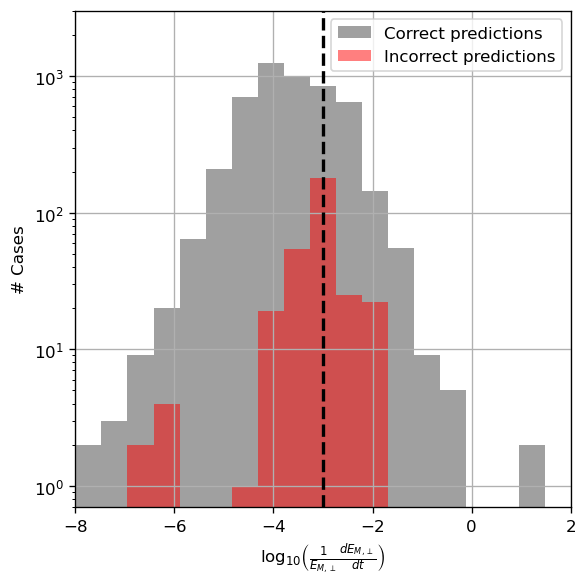

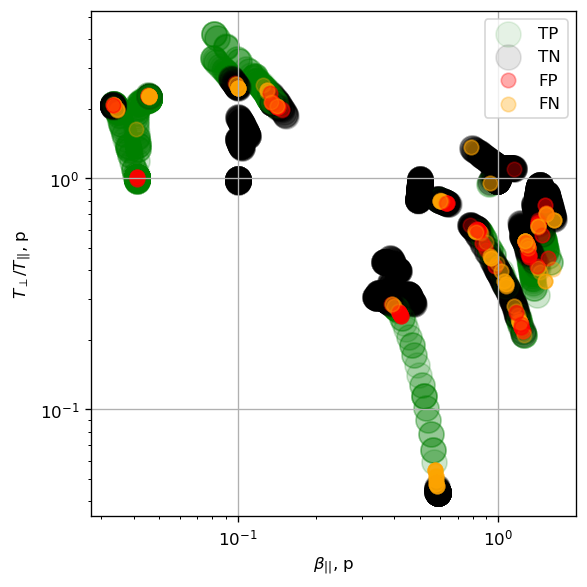

In [16]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_allps.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_allps.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_allps.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_allps.npy')

# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

scaler = StandardScaler()
scaler.fit(featurevector_allmoments[:,:20])
featurevector_allmoments[:,:20] = scaler.transform(featurevector_allmoments[:,:20])

data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)

data_split.split(labels_allmoments)

indexes_tp_all = []
indexes_tn_all = []
indexes_fp_all = []
indexes_fn_all = []

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print("Processing:", i)
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(C=1000.0, class_weight=None, gamma=0.01, kernel='rbf')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    indexes_tp, indexes_tn, indexes_fp, indexes_fn = outputclass_indexes(f_test, f_predicted)
    indexes_tp_all.append(test_index[indexes_tp])
    indexes_tn_all.append(test_index[indexes_tn])
    indexes_fp_all.append(test_index[indexes_fp])
    indexes_fn_all.append(test_index[indexes_fn])

# Histogram for predicted rates
re_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_re_all.npy')
re_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_re_all.npy')

re_max = np.copy(np.abs(re_me))
    
cases_positive = []
cases_negative = []

for i in range (0, 10, 1):
    cases_positive.extend(re_max[indexes_tp_all[i]])
    cases_positive.extend(re_max[indexes_tn_all[i]])
    cases_negative.extend(re_max[indexes_fp_all[i]])
    cases_negative.extend(re_max[indexes_fn_all[i]])
    
cases_positive = np.array(cases_positive)
cases_negative = np.array(cases_negative)

matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(5,5), dpi=120)

plt.grid(True)

bins = np.linspace(-8, 2, 20)
ax.hist(np.log10(cases_positive), color='gray', alpha=0.75, bins=bins, label='Correct predictions')
ax.hist(np.log10(cases_negative), color='red', alpha=0.50, bins=bins, label='Incorrect predictions')
ax.plot([-3,-3], [0.7, 3000.0], color='black', linestyle='--', linewidth=2.0)

ax.set(yscale='log', xlabel=r'log$_{10}\left(\frac{1}{E_{M,\perp}}\frac{dE_{M,\perp}}{dt}\right)$', \
       ylabel=r'# Cases', ylim=[0.7,3000.0], xlim=[-8,2])
ax.legend()

plt.tight_layout()
plt.savefig('./visualizations_paper/histogram_SVM_magrates_norm.png')
plt.show()


    
# visualization in anisotrpy - beta space
    
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_allps.npy')
p_an = featurevector_allmoments[:,16]
p_be = featurevector_allmoments[:,2]

matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(5,5), dpi=120)

plt.grid(True)

for i in range (0, 10, 1):
    if (i == 0):
        ax.scatter(p_be[indexes_tp_all[i]], p_an[indexes_tp_all[i]], color='green', alpha=0.10, label='TP', s=225)
        ax.scatter(p_be[indexes_tn_all[i]], p_an[indexes_tn_all[i]], color='black', alpha=0.10, label='TN', s=225)
    else:
        ax.scatter(p_be[indexes_tp_all[i]], p_an[indexes_tp_all[i]], color='green', alpha=0.10, s=225)
        ax.scatter(p_be[indexes_tn_all[i]], p_an[indexes_tn_all[i]], color='black', alpha=0.10, s=225)
        
for i in range (0, 10, 1):
    if (i == 0):
        ax.scatter(p_be[indexes_fp_all[i]], p_an[indexes_fp_all[i]], color='red', alpha=0.33, label='FP', s=75)
        ax.scatter(p_be[indexes_fn_all[i]], p_an[indexes_fn_all[i]], color='orange', alpha=0.33, label='FN', s=75)
    else:
        ax.scatter(p_be[indexes_fp_all[i]], p_an[indexes_fp_all[i]], color='red', alpha=0.33, s=75)
        ax.scatter(p_be[indexes_fn_all[i]], p_an[indexes_fn_all[i]], color='orange', alpha=0.33, s=75)

ax.set(xscale='log', yscale='log', xlabel=r'$\beta{}_{||}$, p', ylabel=r'$T_{\perp}/T_{||}$, p')
ax.legend()
    
plt.tight_layout()
plt.savefig('./visualizations_paper/parameterspace_SVM_norm.png')
plt.show()